# Description

- Initialize with returns, predictions, target volatility, and oos start date
- Evaluate portfolios generated from the predictions

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import core.config as cconfig
import core.dataflow_model.model_evaluator as modeval
import core.dataflow_model.model_plotter as modplot
import core.dataflow_model.utils as cdmu
import helpers.dbg as dbg
import helpers.printing as hprint

In [2]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

# _LOG.info("%s", env.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-c7b029a1-fe27-4e55-8ea2-1e94a390a1af.json'


In [19]:
# import matplotlib
# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 32}

# matplotlib.rc('font', **font)

import matplotlib.pyplot as plt

scale = 3

SMALL_SIZE = 8 * scale
MEDIUM_SIZE = 10 * scale
BIGGER_SIZE = 12 * scale

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



# Notebook config

In [4]:
exp_dir = "/app/experiment1"

eval_config = cconfig.get_config_from_nested_dict(
    {
        "exp_dir": exp_dir,
        "model_evaluator_kwargs": {
            "returns_col": "ret_0_vol_adj_2",
            "predictions_col": "ret_0_vol_adj_2_hat",
            #"oos_start": "2017-01-01",
        },
        "bh_adj_threshold": 0.1,
        "resample_rule": "W",
        "mode": "ins",
        "target_volatility": 0.1,
    }
)

# Initialize ModelEvaluator and ModelPlotter

In [5]:
# Load the data.
result_bundles = cdmu.yield_experiment_artifacts(
    eval_config["exp_dir"],
    "result_bundle.pkl",
)

# Build the ModelEvaluator.
evaluator = modeval.build_model_evaluator_from_result_bundles(
    result_bundles,
    abort_on_error=False,
    **eval_config["model_evaluator_kwargs"].to_dict(),
)

# Build the ModelPlotter.
plotter = modplot.ModelPlotter(evaluator)

Found 46 experiment subdirs in '/app/experiment.RH1E.5T.20210728-16_05_30'


Loading artifacts:   0%|          | 0/46 [00:00<?, ?it/s]

Can't find '/app/experiment.RH1E.5T.20210728-16_05_30/result_45/result_bundle.pkl': skipping


# Analysis

In [6]:
pnl_stats = evaluator.calculate_stats(
    mode=eval_config["mode"], target_volatility=eval_config["target_volatility"]
)
display(pnl_stats)

Calculating positions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating stats:   0%|          | 0/45 [00:00<?, ?it/s]

maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


/venv/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


0                          1                          2                          3                          4                          5                          6                          7                          8                          9                          10                         11                         12                         13                         14                         15                         16                         17                         18                         19                         20                         21                         22                         23                         24                         25                         26                         27                         28                         29                         30                         31                         32                         33                         34  \
finance        avg_turnover_(%)                                       31.763533                   20.96564                  20.167052                   23.32998                  23.292577                  29.571534                  22.733311                  33.706216                  104.25908                  35.567504                  19.377564                  27.211583                  23.457003                  22.651611                  31.314802                   36.01484                  36.941659                  21.921623                  39.802024                  23.710827                   26.46811                   20.59823                  36.398688                  27.631615                  18.939984                  33.779138                  29.374527                  26.384788                  27.639924                   25.69851                   20.65457                  27.791747                  29.534634                  25.239926                  29.334543   
               turnover_frequency                                      <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>                   <Minute>   
               avg_holding_period                                      3.148264                   4.769709                   4.958583                    4.28633                   4.293213                    3.38163                   4.398831                   2.966812                   0.959149                   2.811555                   5.160607                   3.674906                   4.263119                   4.414697                   3.193378                   2.776633                   2.706971                   4.561706                   2.512435                   4.217483                   3.778132                   4.854786                   2.747352                   3.619043                   5.279835                   2.960407                    3.40431                   3.790063                   3.617955                   3.891276                   4.841544                    3.59819                   3.385855                   3.961977                    3.40895   
               holding_period_units                                    <M

## Model selection

Calculating positions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/45 [00:00<?, ?it/s]

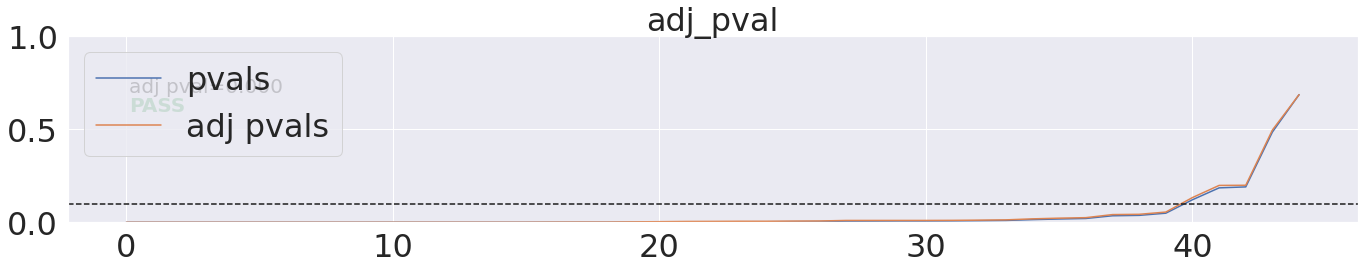

In [7]:
plotter.plot_multiple_tests_adjustment(
    threshold=eval_config["bh_adj_threshold"], mode=eval_config["mode"]
)

In [8]:
# TODO(gp): Move this chunk of code in a function.
col_mask = (
    pnl_stats.loc["signal_quality"].loc["sr.adj_pval"]
    < eval_config["bh_adj_threshold"]
)
selected = pnl_stats.loc[:, col_mask].columns.to_list()
not_selected = pnl_stats.loc[:, ~col_mask].columns.to_list()

print("num model selected=%s" % hprint.perc(len(selected), pnl_stats.shape[1]))
print("model selected=%s" % selected)
print("model not selected=%s" % not_selected)

# Use `selected = None` to show all the models.

num model selected=40 / 45 = 88.89%
model selected=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42]
model not selected=[8, 37, 38, 43, 44]


Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

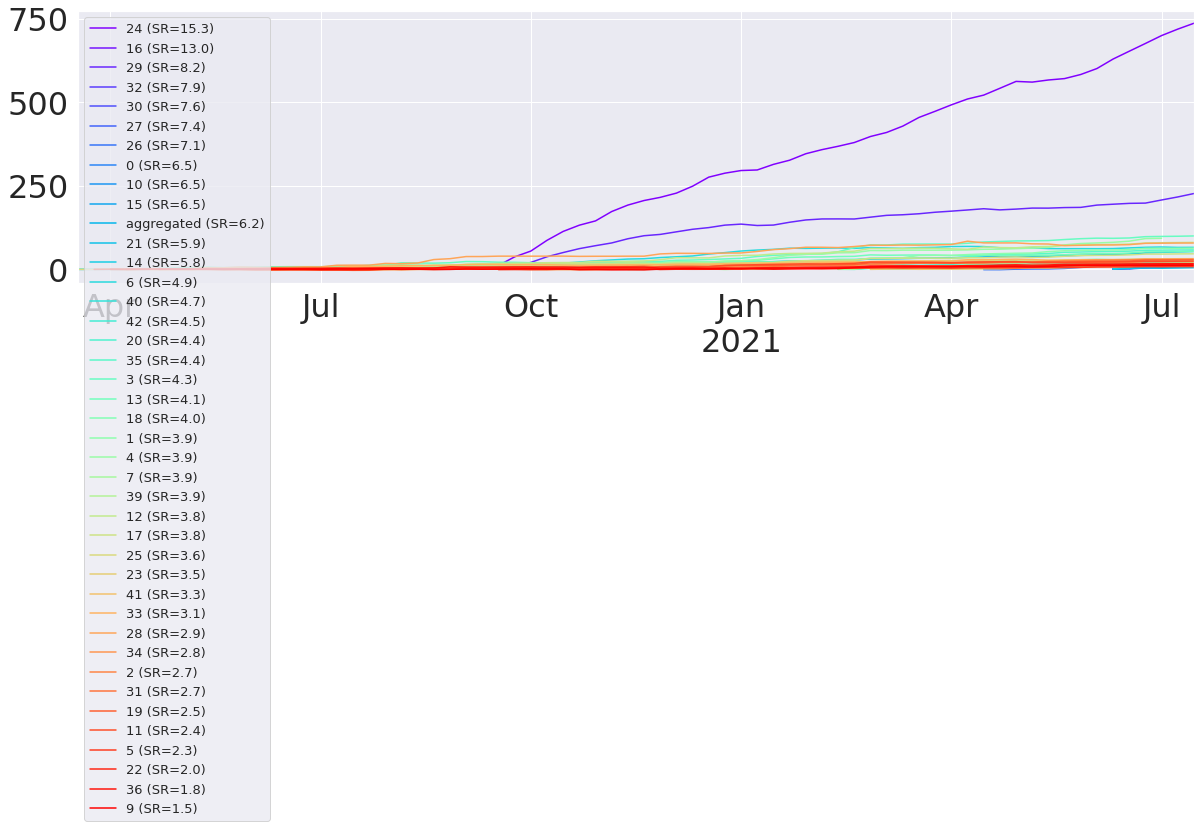

In [9]:
plotter.plot_multiple_pnls(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Return correlation

Calculating positions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/45 [00:00<?, ?it/s]

The corr_df.shape[0]='45' > 20


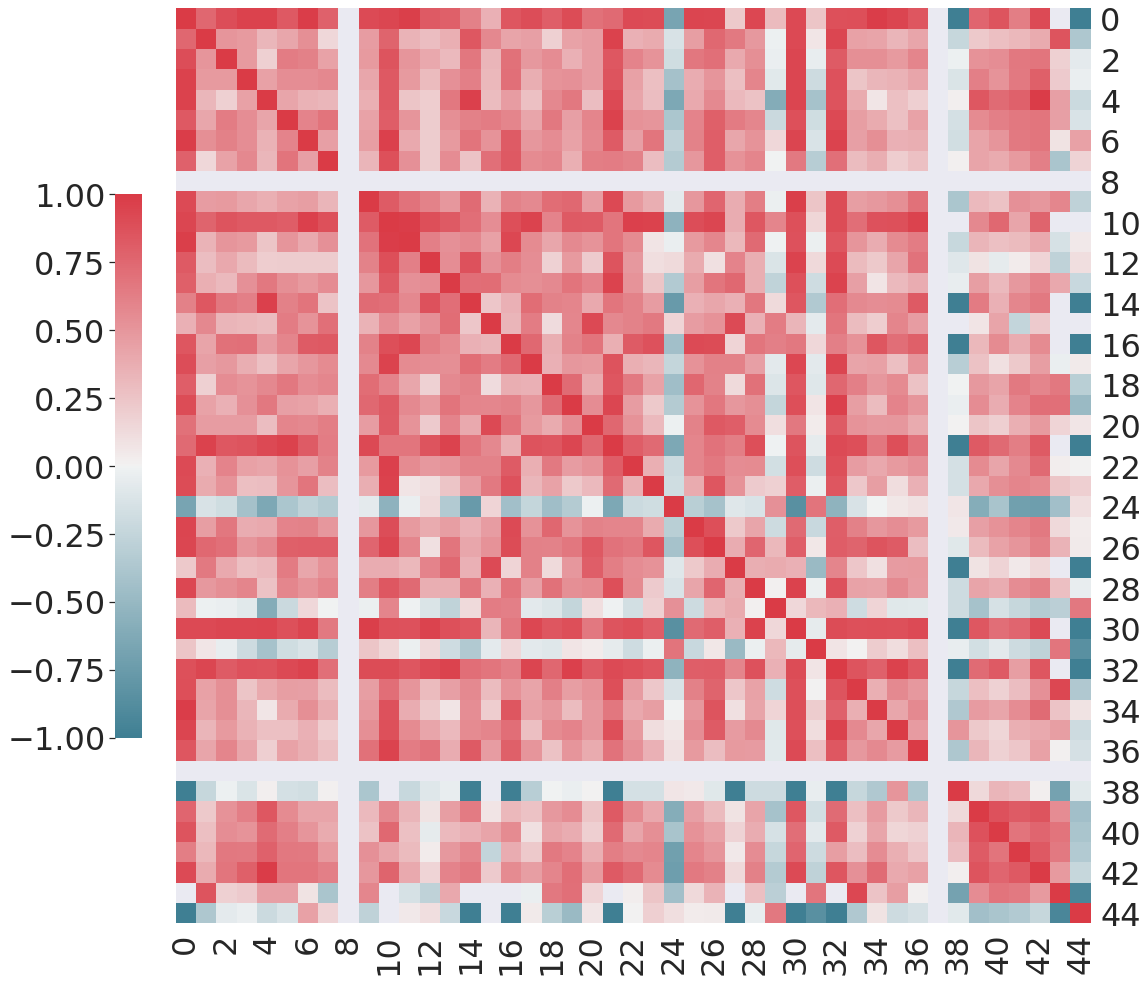

In [10]:
plotter.plot_correlation_matrix(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Model correlation

Calculating positions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/45 [00:00<?, ?it/s]

The corr_df.shape[0]='45' > 20


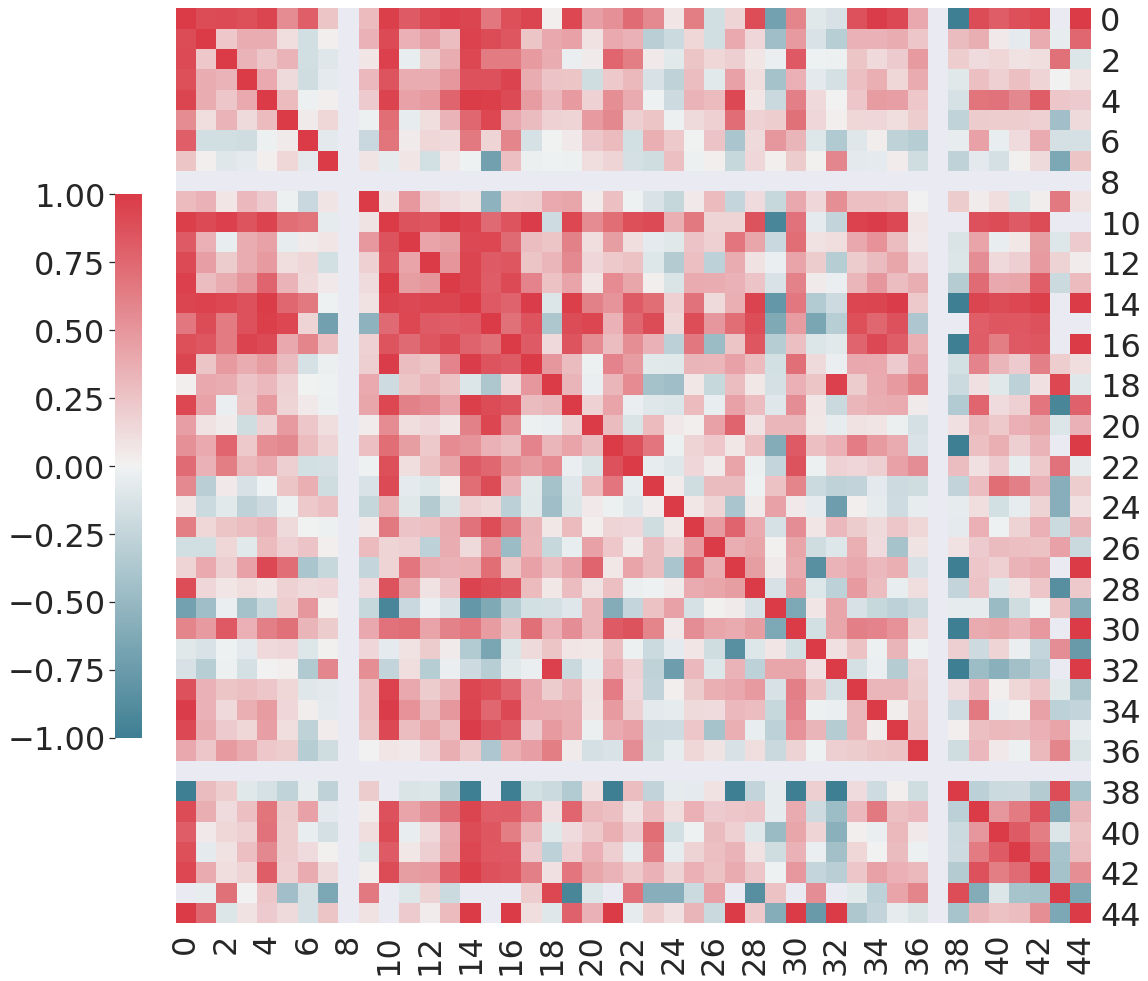

In [11]:
plotter.plot_correlation_matrix(
    series="pnl",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Aggregate model

In [12]:
pnl_srs, pos_srs, aggregate_stats = evaluator.aggregate_models(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)
display(aggregate_stats)

Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

finance         avg_turnover_(%)                                     23.796639
                turnover_frequency                                    <Minute>
                avg_holding_period                                    4.202274
                holding_period_units                                  <Minute>
sampling        start_time                           2020-03-17 12:17:00-04:00
                end_time                             2021-07-16 15:58:00-04:00
                n_sampling_points                                       133506
                frequency                                             <Minute>
                sampling_points_per_year                            525780.125
                time_span_in_years                                    1.331473
                n_rows                                                975281.0
                frac_zero                                               0.0003
                frac_nan                            

Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

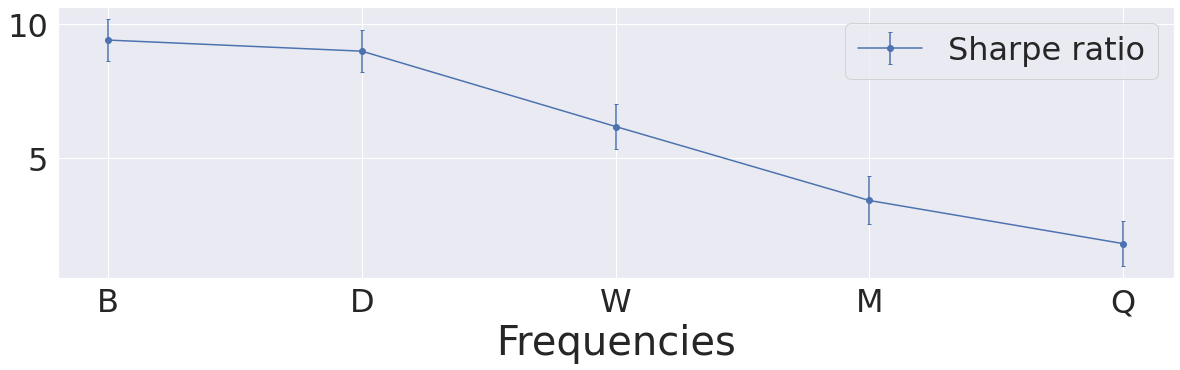

In [13]:
plotter.plot_sharpe_ratio_panel(keys=selected, mode=eval_config["mode"])

Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 98, using nperseg = 98
  warnings.warn('nperseg = {0:d} is greater than input length '
/venv/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 98, using nperseg = 98
  warnings.warn('nperseg = {0:d} is greater than input length '
/app/amp/core/plotting.py:735: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(t, f_sxx, Sxx)


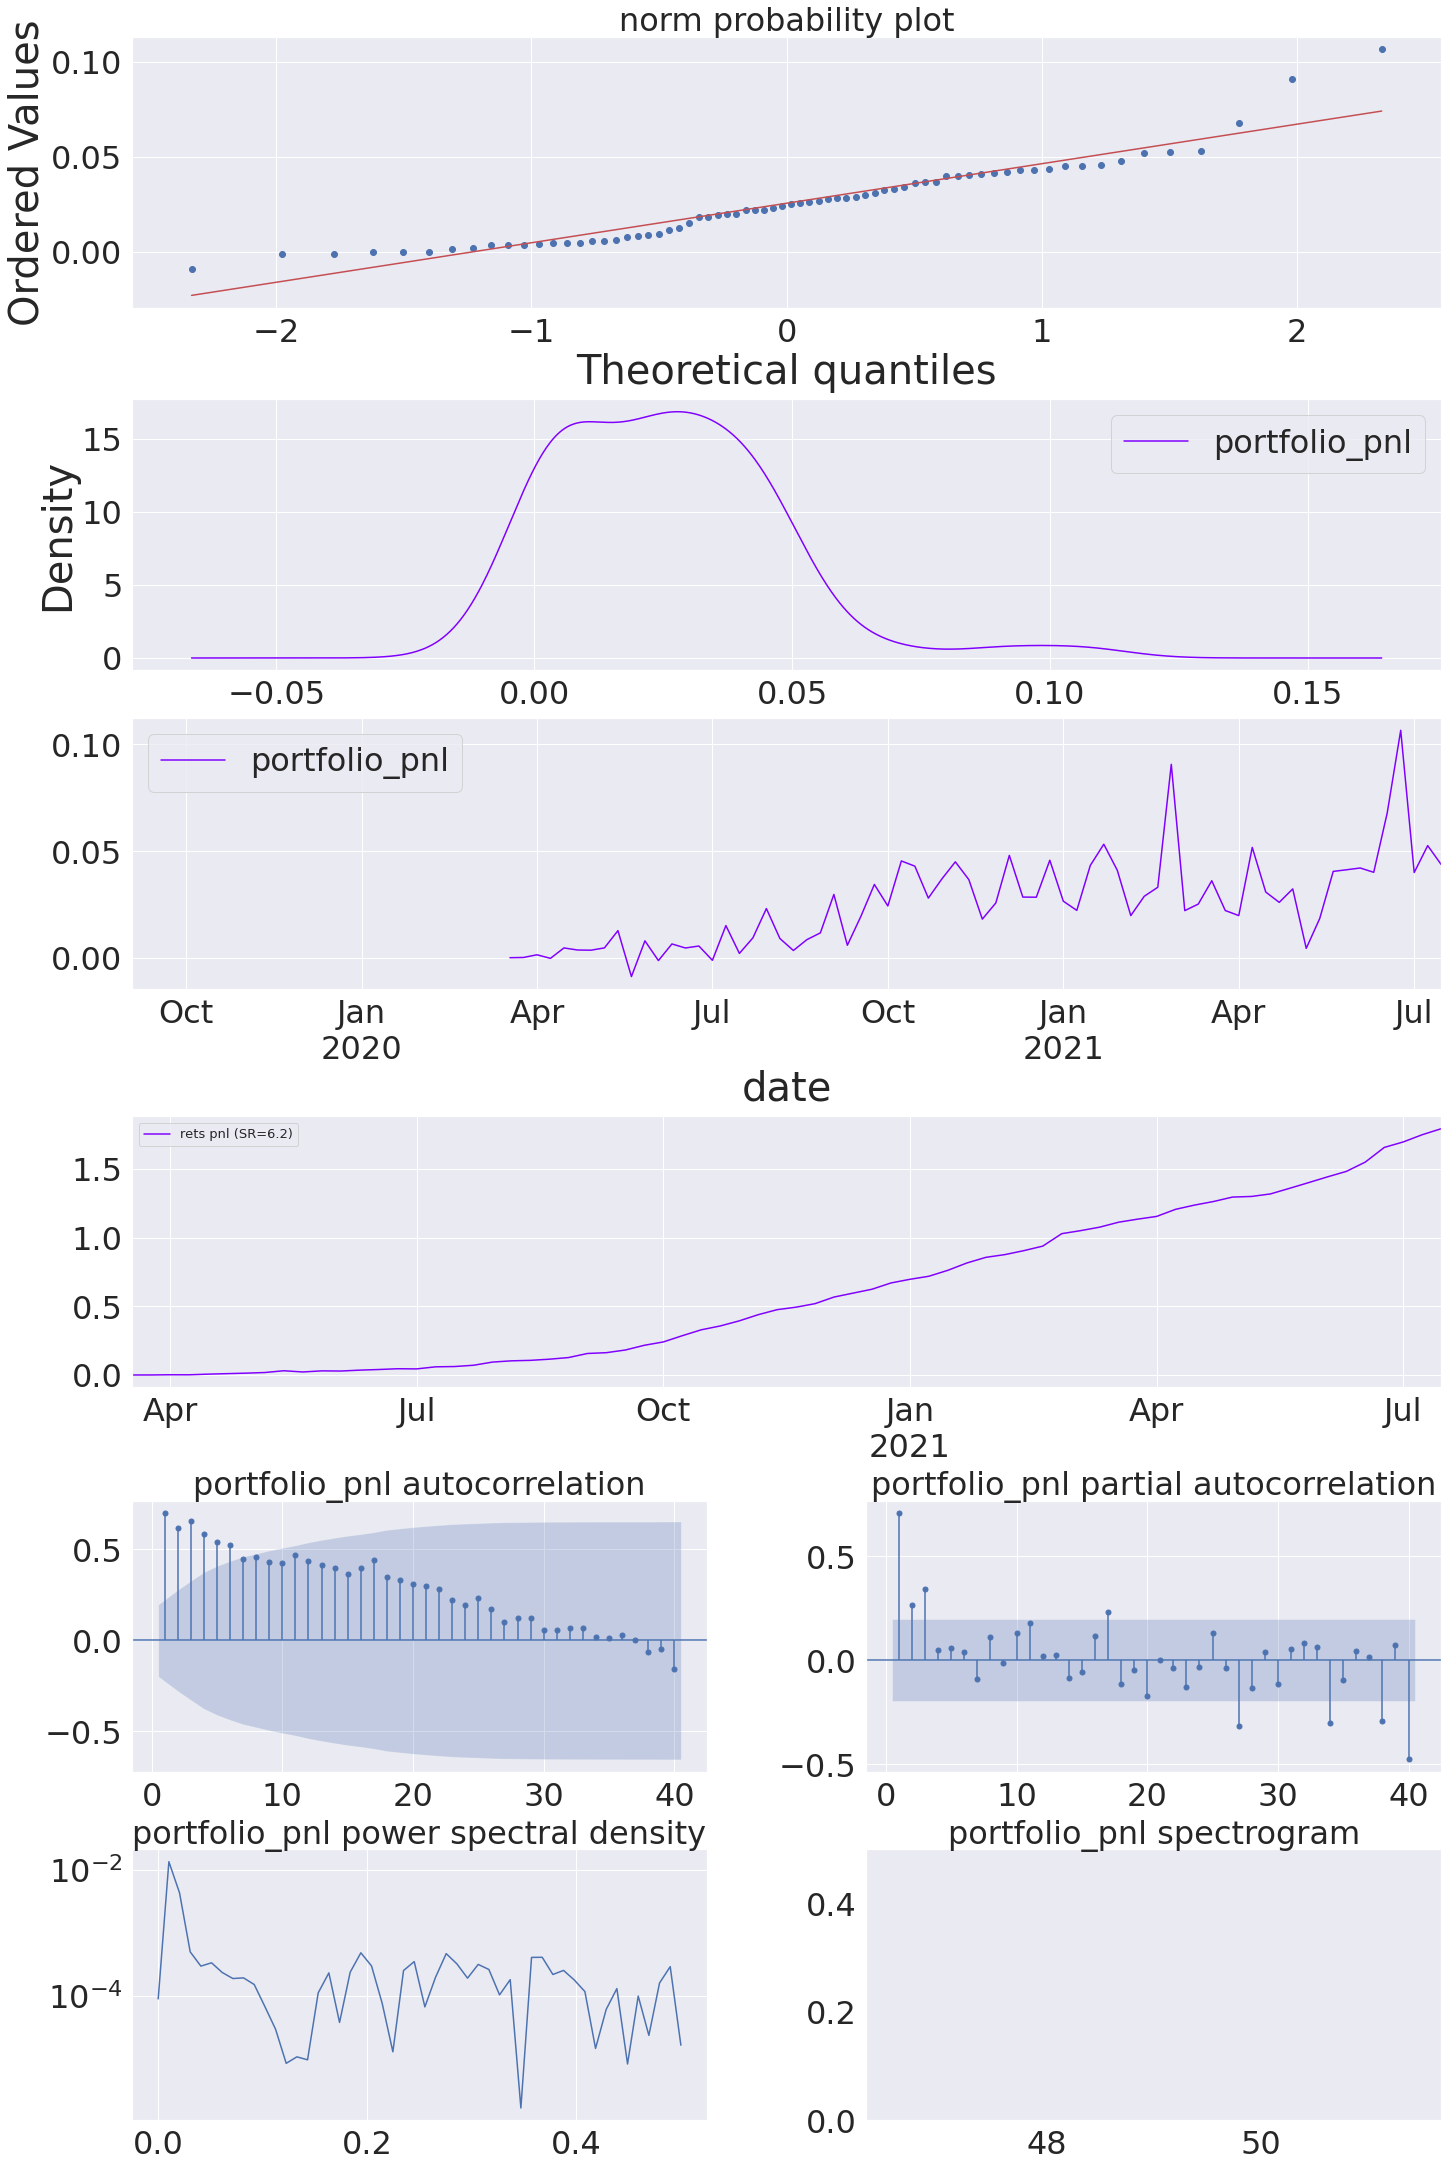

In [14]:
plotter.plot_rets_signal_analysis(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

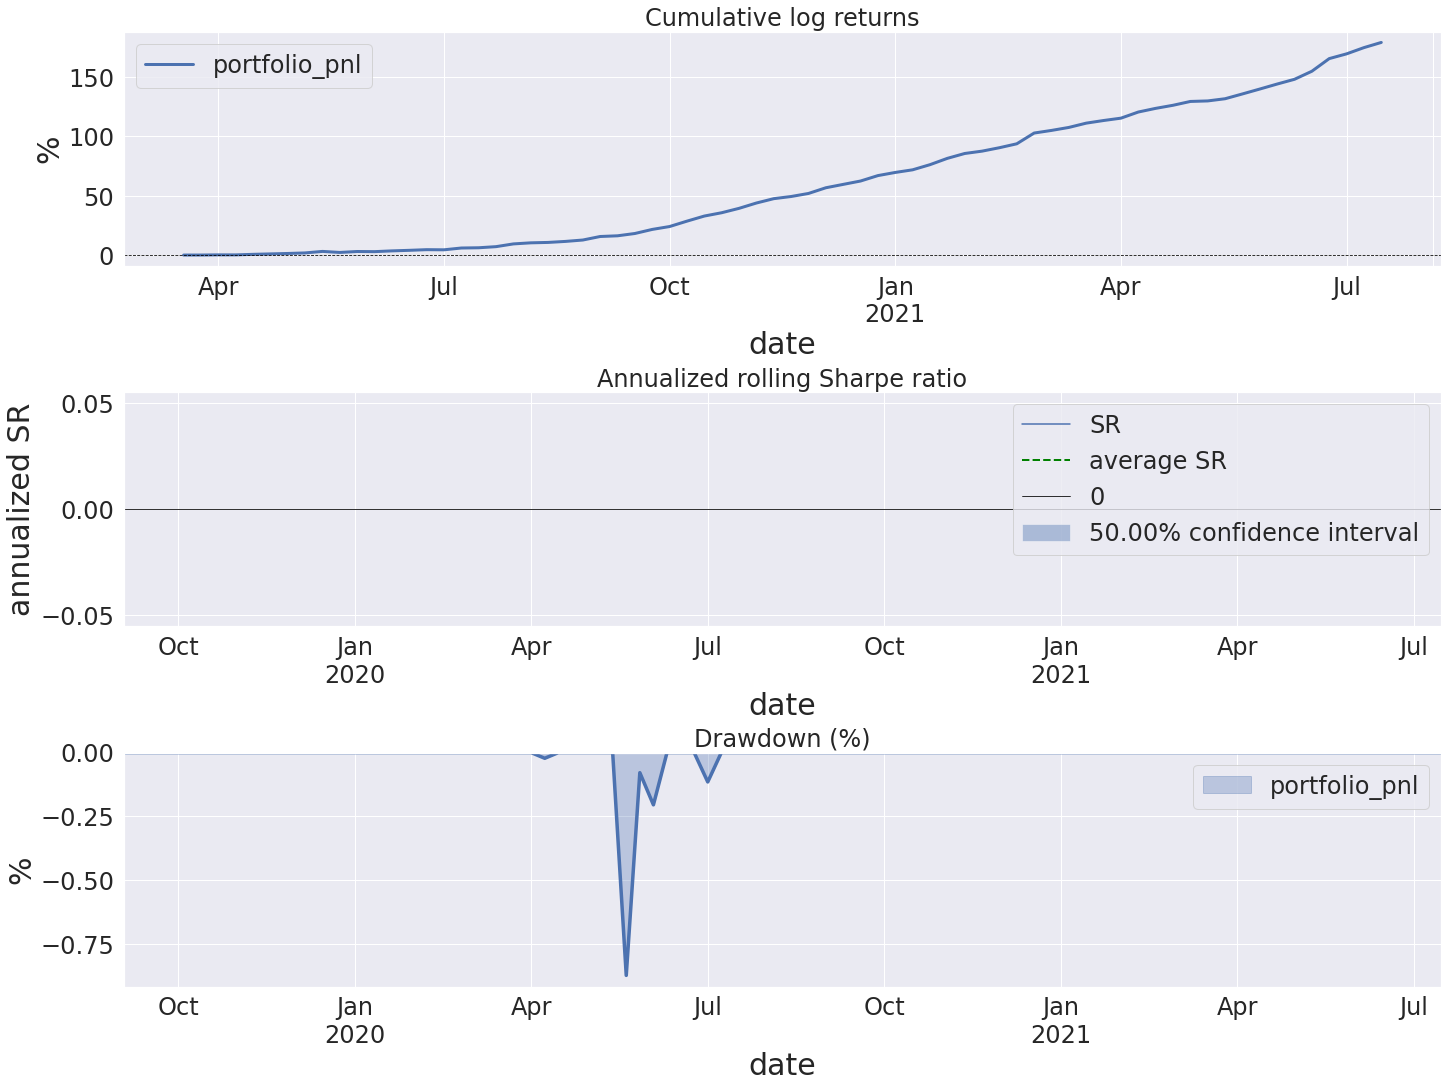

In [20]:
plotter.plot_performance(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

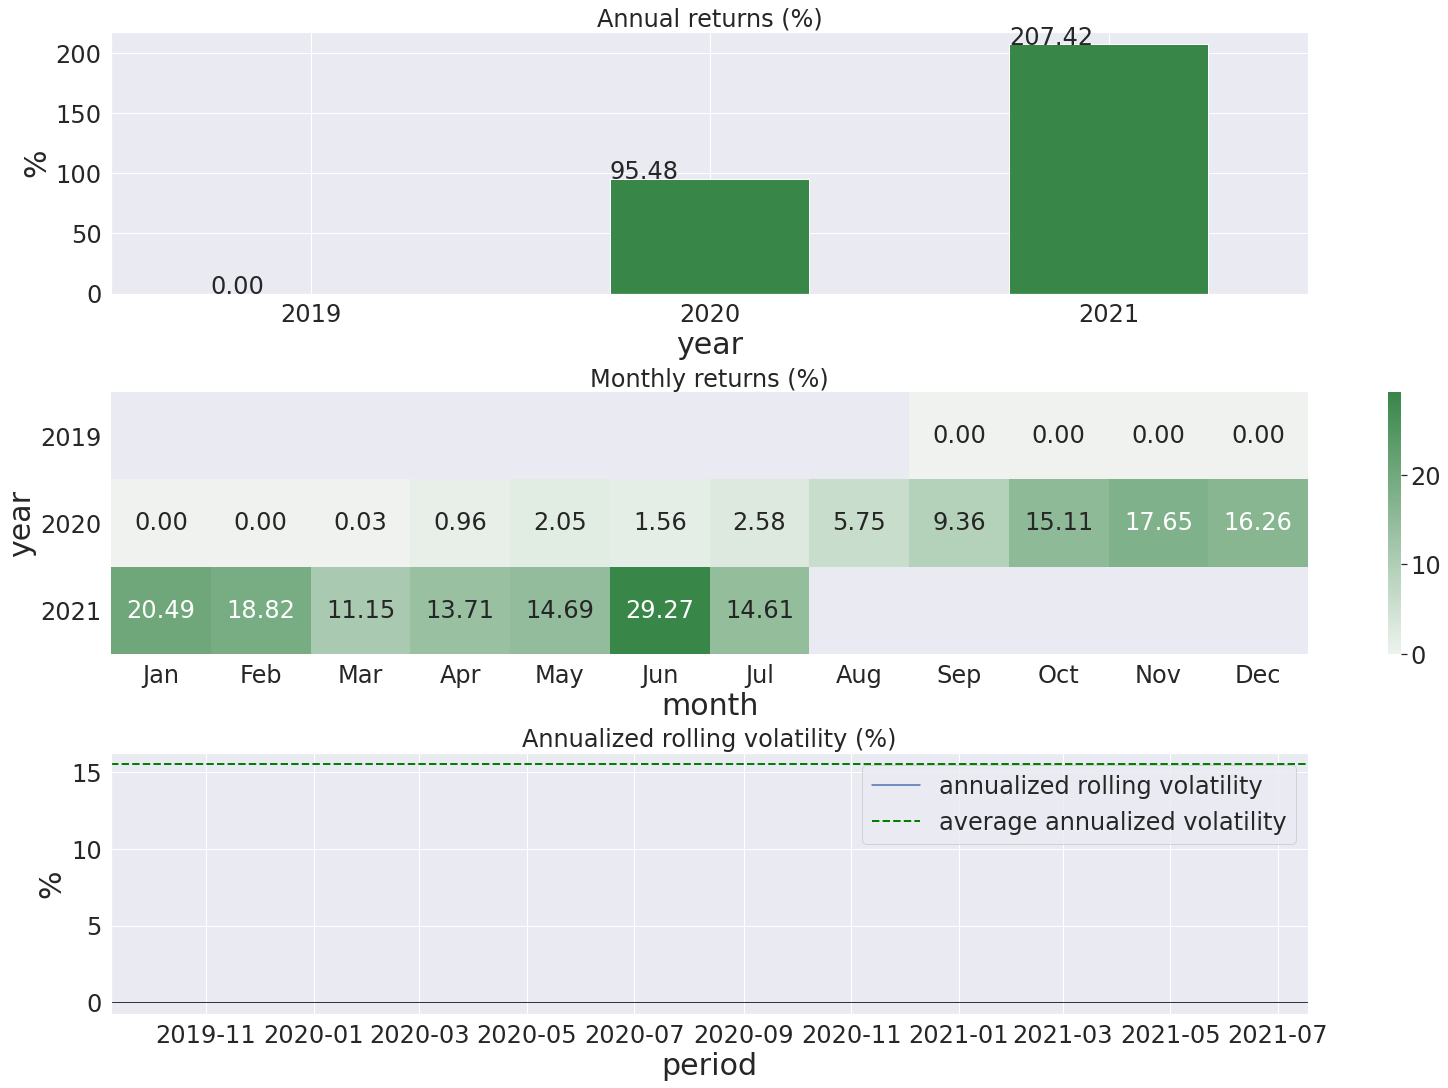

In [21]:
plotter.plot_rets_and_vol(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/40 [00:00<?, ?it/s]

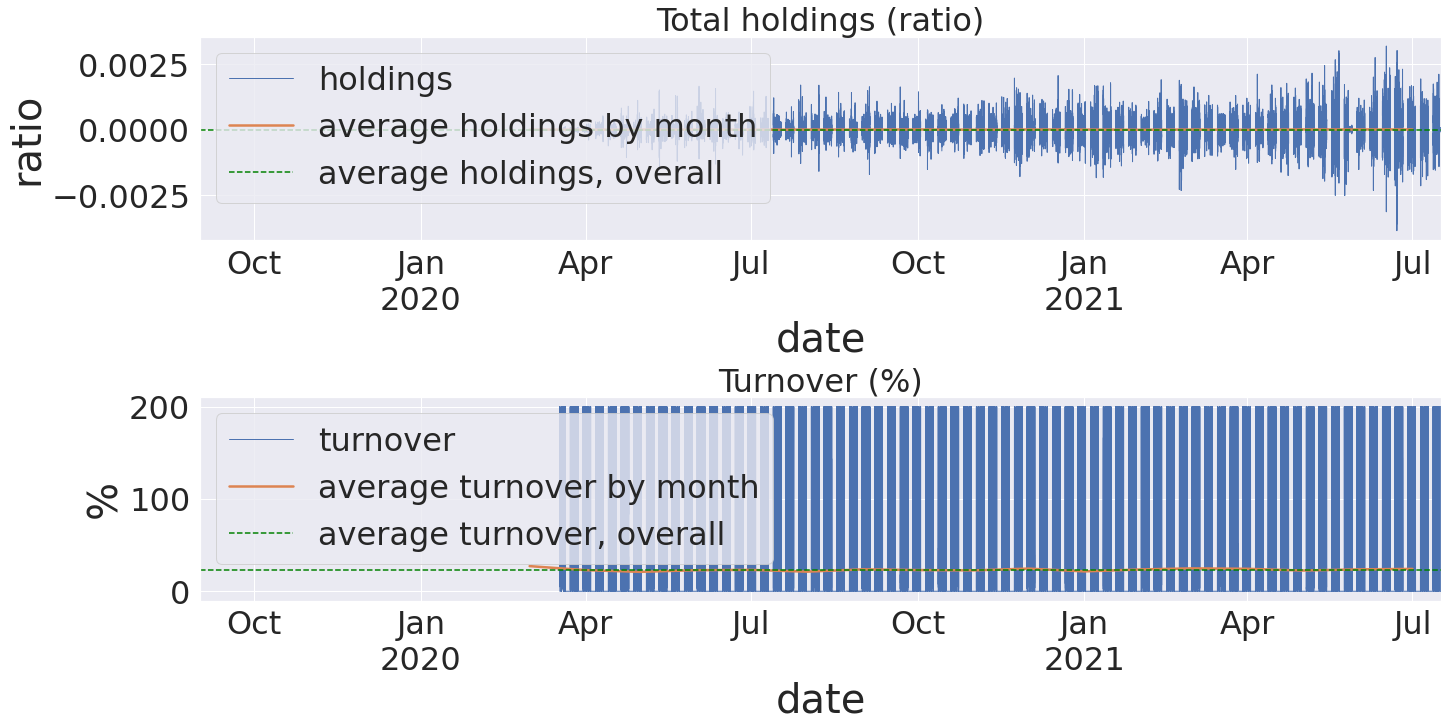

In [17]:
plotter.plot_positions(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/1 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


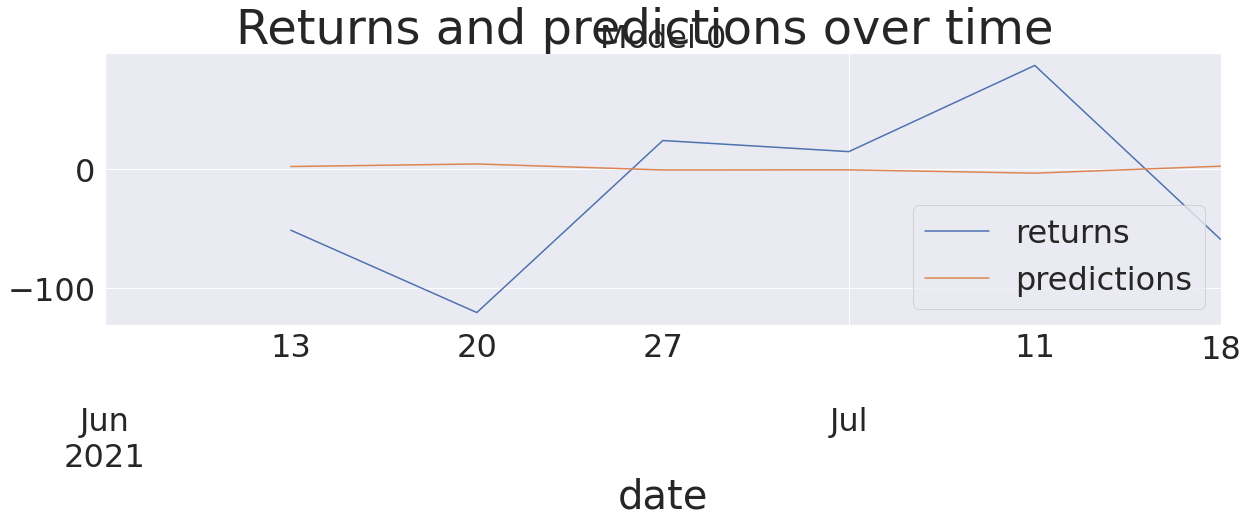

In [18]:
# Plot the returns and prediction for one or more models.
model_key = selected[:1]
plotter.plot_returns_and_predictions(
    keys=model_key,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)